Per a aquest projecte, farem servir un conjunt de dades de l'IMDB amb 50.000 ressenyes de pel·lícules disponible a Kaggle. Aquest conjunt de dades consta de dues columnes (resenya i sentiment) que ens ajudaran a identificar si una resenya és positiva o negativa.
La base de dades està disponible a 

Altres bases de dades:
https://www.kaggle.com/code/lakshmi25npathi/sentiment-analysis-of-imdb-movie-reviews


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SV
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV


ImportError: cannot import name 'SV' from 'sklearn.svm' (/Users/eda/anaconda3/lib/python3.10/site-packages/sklearn/svm/__init__.py)

In [3]:
df = pd.read_csv('kaggle_movies_db.csv')
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


A continuació, explorem les dades del dataset

In [4]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [6]:
df.shape

(50000, 2)

Aquest conjunt de dades conté 50.000 files; no obstant això, per entrenar el nostre model de manera més ràpida en els passos seguents, agafarem una mostra més petita de 10.000 files. Aquesta petita mostra inclourà 9.000 ressenyes positives i 1.000 negatives per desequilibrar les dades.

Amb aquest desequilibri entre les dues classes (positiva i negativa), es crea una situació de undersampling i oversampling, que es seguirà per construir in model més robust:

<strong>Motius per explorar Undersampling:</strong>

Rapidesa d'entrenament: Amb una majoria de ressenyes positives, entrenar el model amb un subconjunt més petit (submostreig) de ressenyes positives pot accelerar el procés sense perdre la informació essencial de la classe majoritària.

Evitar la dominància: Amb tantes ressenyes positives, el model podria centrar-se massa en aquesta classe i ignorar la classe minoritària, afectant la seva habilitat per predir ressenyes negatives amb precisió.

<strong>Motius per explorar Oversampling:</strong>

Millora de la capacitat predictiva: Donada la petita quantitat de ressenyes negatives, fer un sobremostreig d'aquesta classe pot millorar la capacitat del model per reconèixer i aprendre patrons específics d'aquesta classe.

Reducció del desequilibri: L'oversampling aborda el desequilibri inherent, assegurant que el model no estigui sesgat cap a la classe majoritària i pugui fer prediccions més equitatives per ambdues classes.



In [14]:
df_positive = df[df['sentiment']=='positive'][:9000]
df_negative = df[df['sentiment']=='negative'][:1000]

Fem una comprovació ràpida al dataframe per veure si s'han dividit correctament.

In [11]:
df_positive.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive


In [13]:
df_negative.head()

,review,sentiment
3,Basically there's a family where a little boy ...,negative
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
10,Phil the Alien is one of those quirky films wh...,negative
11,I saw this movie when I was about 12 when it c...,negative


Ara, concatenem els dataframes amb el nou mostreig

In [15]:
df_review_imb = pd.concat([df_positive, df_negative])

In [16]:
df_review_imb

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
...,...,...
2000,Stranded in Space (1972) MST3K version - a ver...,negative
2005,"I happened to catch this supposed ""horror"" fli...",negative
2007,waste of 1h45 this nasty little film is one to...,negative
2010,Warning: This could spoil your movie. Watch it...,negative


Visualitzem el nou dataset en un gràfic de barres

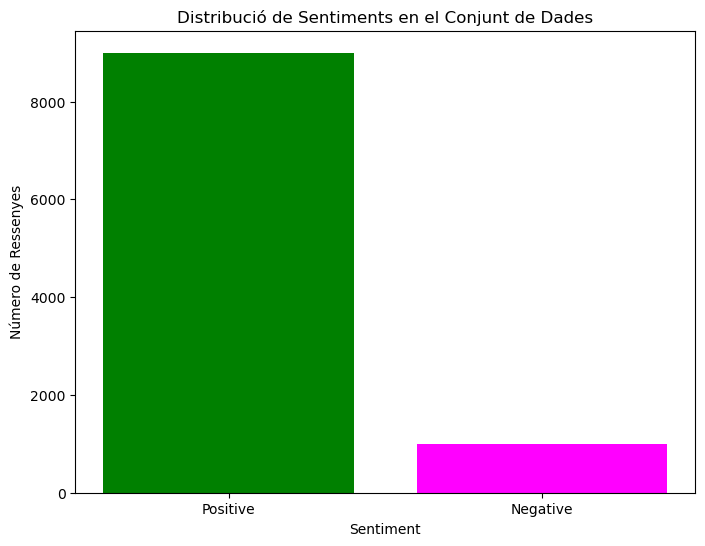

In [22]:
# Comptatge del nombre de ressenyes per classe
positive_count = df_positive.shape[0]
negative_count = df_negative.shape[0]

# Creació del gràfic de barres
plt.figure(figsize=(8, 6))
plt.bar(['Positive', 'Negative'], [positive_count, negative_count], color=['green', 'magenta'])

plt.xlabel('Sentiment')
plt.ylabel('Número de Ressenyes')
plt.title('Distribució de Sentiments en el Conjunt de Dades')

plt.show()

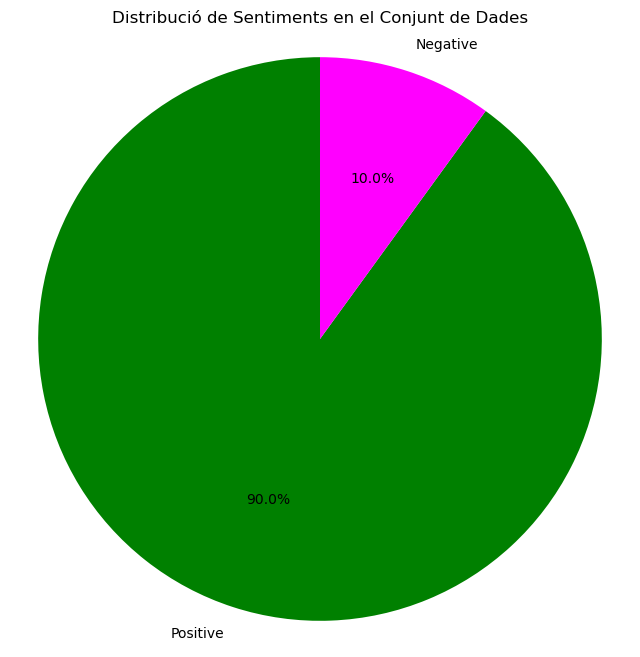

In [23]:
total_count = positive_count + negative_count
positive_percentage = (positive_count / total_count) * 100
negative_percentage = (negative_count / total_count) * 100

# Crea una figura de gràfic de sectors
plt.figure(figsize=(8, 8))

# Dibuixa el gràfic de sectors amb percentatges i comptes
labels = ['Positive', 'Negative']
sizes = [positive_count, negative_count]
percentages = [positive_percentage, negative_percentage]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['green', 'magenta'])

# Afegir etiquetes i títol
plt.axis('equal')  # Assegura que el gràfic de sectors sigui circular
plt.title('Distribució de Sentiments en el Conjunt de Dades')

# Mostra el gràfic
plt.show()

## Imbalanced learn

Per reequilibrar les nostres dades, fem servir la biblioteca imbalanced-learn (imblearn). Per al nostre projecte, farem servir la tècnica de undersampling RandomUnderSampler.

In [33]:
from imblearn.under_sampling import RandomUnderSampler

# desbalanceado
df_review_des = pd.concat([df_positive, df_negative])
df_review_des.value_counts('sentiment')

rus = RandomUnderSampler()
df_review_bal, df_review_bal['sentiment'] = rus.fit_resample(df_review_des[['review']], df_review_des['sentiment'])

df_review_bal.value_counts(['sentiment'])

sentiment
negative     1000
positive     1000
dtype: int64

Per reequilibrar les dades hem fet servir la tècnica de mostreig aleatori (RandomUnderSampler) per reduir el nombre de mostres de la classe majoritària (en aquest cas, la classe "positive") per igualar-lo al nombre de mostres de la classe minoritària (la classe "negative"). Després d'aplicar l'undersampling, s'obté un nou conjunt de dades (df_review_bal) amb 1000 mostres de cada classe.

El resultat indica que s'ha aconseguit un balanç perfecte (1000 registres en concret per cada classe) entre les dues classes després de l'aplicació de l'undersampling.

## Train-Test

Ara anem a dividir les nostres dades en dos congunts: un conjunt d'entrenament i un conjunt de proves. El conjunt d'entrenament s'utilitzarà per ajustar el model, mentres que el conjunt de proves es farà servir per proporcionar una avaluació imparcial d'un model final ajustat al conjunt d'entrenament.

Per dur a terme aquesta divisió, farem servir la funció <strong>train_test_split</strong> de la llibreria sklearn. En aquest cas, establim que el 33% de les dades es destinaran al conjunt de proves. Això significa que el 67% restant es farà servir com a conjunt d'entrenament.

La divisió de les dades en conjunts d'entrenament i proves ha de ser representatiu del conjunt de dades original per obtenir una avaluació precisa del model. A més, la divisió aleatòria de les dades ajuda a evitar l'overfitting del model als patrons específics del conjunt d'entrenament.

In [35]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_review_bal, test_size=0.33, random_state=42)

train_x, train_y = train['review'], train['sentiment']
test_x, test_y = test['review'], test['sentiment']

El conjunt de dades s'ha dividit en un conjunt d'entrenament i un conjunt de proves. Explico les variables resultants d'aquesta divisió:

train_x: Variables independents (review) que s'utilitzaran per entrenar el model. Com s'ha especificat test_size = 0.33, el 67% de les observacions del conjunt de dades es faran servir per ajustar el model.

train_y: Variables dependents (sentiment) o etiqueta objectiu que ha de ser predita per aquest model.

test_x: El 33% restant de les variables independents que es faran servir per fer prediccions per provar l'exactitud del model.

test_y: Les etiquetes de les categories que es faran servir per provar l'exactitud entre les categories reals i les categories predites.

Aquesta divisió serveix bàsicament per avaluar el rendiment del model en dades noves i no vistes durant l'entrenament. Per tant, el conjunt d'entrenament s'utilitza per ajustar el model, mentre que el conjunt de proves es fa servir per avaluar la seva precisió en dades noves.

Per visualitzar el resultat, imprimim les variables:

In [39]:
print("Distribució de Sentiments - Conjunt d'Entrenament:")
print(train_sentiment_counts)

print("\nDistribució de Sentiments - Conjunt de Proves:")
print(test_sentiment_counts)

Distribució de Sentiments - Conjunt d'Entrenament:
negative    675
positive    665
Name: sentiment, dtype: int64

Distribució de Sentiments - Conjunt de Proves:
positive    335
negative    325
Name: sentiment, dtype: int64


També en podem visualitzar els diferents conjuns de dades en gràfiques, on veiem que la distribució és molt similar:

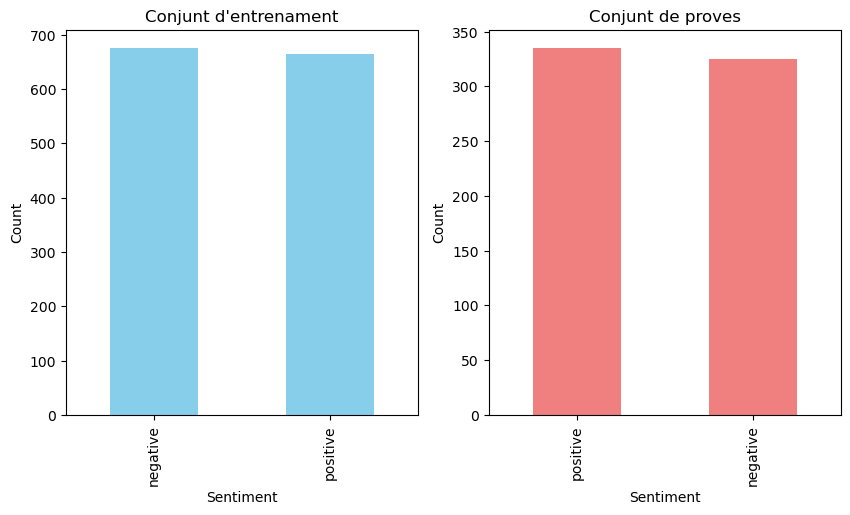

In [36]:
# Comptatge
train_sentiment_counts = train_y.value_counts()
test_sentiment_counts = test_y.value_counts()

# Gràfic
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
train_sentiment_counts.plot(kind='bar', ax=ax[0], color='skyblue')
ax[0].set_title('Conjunt d\'entrenament')
ax[0].set_xlabel('Sentiment')
ax[0].set_ylabel('Count')
test_sentiment_counts.plot(kind='bar', ax=ax[1], color='lightcoral')
ax[1].set_title('Conjunt de proves')
ax[1].set_xlabel('Sentiment')
ax[1].set_ylabel('Count')

plt.show()

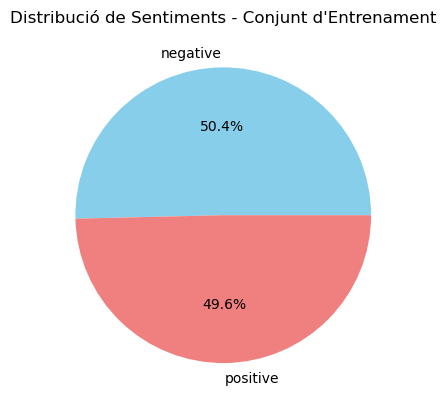

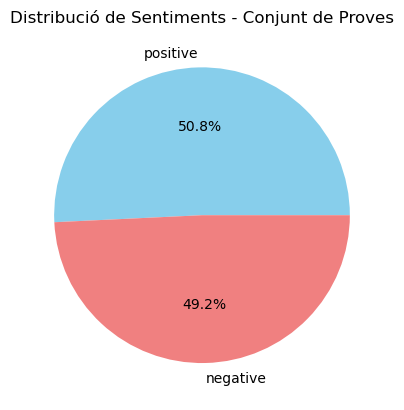

In [38]:
# Train
plt.pie(train_sentiment_counts, labels=train_sentiment_counts.index, autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
plt.title('Distribució de Sentiments - Conjunt d\'Entrenament')
plt.show()

# Test
plt.pie(test_sentiment_counts, labels=test_sentiment_counts.index, autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
plt.title('Distribució de Sentiments - Conjunt de Proves')
plt.show()


En ambdós casos, la distribució de sentiments és lleugerament més gran (<1) en els positius que en els negatius.

En la representació de text, els classificadors i algoritmes d'aprenentatge esperen vectors de característiques numèriques en comptes de documents de text en brut. Aquesta necessitat deriva de la naturalesa dels models que requereixen dades numèriques per funcionar adequadament.

Per aconseguir això en el nostre context de ressenyes de pel·lícules, hem d'aconseguir convertir el text de les ressenyes en vectors numèrics. Existeixen diverses tècniques per representar el text, com ara la codificació one-hot, la bossa de paraules (Bag of Words) i Word2Vec.

## Bag of Words(BOW)

Aquesta tècnica converteix els documents de text en vectors de longitud fixa comptant quants cops apareix cada paraula en el document.

Per aplicar la representació de la BOW, es poden utilitzar diverses tècniques com ara CountVectorizer i Term Frequency-Inverse Document Frequency (TF-IDF). El CountVectorizer simplement compta quants cops apareix cada paraula en un document, mentre que el TF-IDF ajusta aquestes freqüències en funció de la seva importància en tots els documents del conjunt de dades.

La representació de la BOW és útil quan es volen tenir en compte les freqüències de les paraules en els documents, però no la seva ordre. Això és particularment útil en tasques on la semàntica de les paraules és més rellevant que la seva estructura gramatical o la seva seqüència.

En aquesta tasca, optarem per utilitzar el CountVectorizer i el Term Frequency-Inverse Document Frequency (TF-IDF).

### Count Vectorizer

In [44]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Creem una instància de CountVectorizer
cv = CountVectorizer()

# Transformem les ressenyes d'entrenament en una matriu de comptadors
train_x_vector = cv.fit_transform(train_x)

# Transformem les ressenyes de prova en una matriu de comptadors
test_x_vector = cv.transform(test_x)

# Creem un DataFrame amb les matrius de comptadors per a les ressenyes d'entrenament i de prova
df_train_vector = pd.DataFrame(train_x_vector.toarray(), columns=cv.get_feature_names_out())
df_test_vector = pd.DataFrame(test_x_vector.toarray(), columns=cv.get_feature_names_out())

# Visualitzem el DataFrame amb les matrius de comptadors per a les ressenyes d'entrenament
print("DataFrame amb matriu de comptadors per a ressenyes d'entrenament:")
print(df_train_vector)

# Visualitzem el DataFrame amb les matrius de comptadors per a ressenyes de prova
print("\nDataFrame amb matriu de comptadors per a ressenyes de prova:")
print(df_test_vector)


DataFrame amb matriu de comptadors per a ressenyes d'entrenament:
      00  000  007  01pm  02  04  05  10  100  1000  ...  zorro  zuckers  \
0      0    0    0     0   0   0   0   0    0     0  ...      0        0   
1      0    0    0     0   0   0   0   0    0     0  ...      0        0   
2      0    0    0     0   0   0   0   2    0     0  ...      0        0   
3      0    0    0     0   0   0   0   1    0     0  ...      0        0   
4      0    0    0     0   0   0   0   0    0     0  ...      0        0   
...   ..  ...  ...   ...  ..  ..  ..  ..  ...   ...  ...    ...      ...   
1335   0    0    0     0   0   0   0   0    0     0  ...      0        0   
1336   0    0    0     0   0   0   0   0    1     0  ...      0        0   
1337   0    0    0     0   0   0   0   0    0     0  ...      0        0   
1338   0    0    0     0   0   0   0   0    0     0  ...      0        0   
1339   0    0    0     0   0   0   0   0    0     0  ...      0        0   

      zues  zuleta  z

Observem que tenim 20.268 columnes (paraules úniques) en aquest dataframe. Algunes de les cel·les poden contenir el valor 0, ja que una paraula determinada pot no aparèixer en una ressenya específica. 

En la fase següent, aquestes matrius de comptadors es faran servir com a característiques d'entrada per als models de machine learning per predir el sentiment de les ressenyes de pel·lícules.

El següent pas és aplicar la tècnica de representació de text coneguda com a "Term Frequency-Inverse Document Frequency" (TF-IDF) utilitzant l'objecte TfidfVectorizer de la llibreria scikit-learn. Aquest procés implica la transformació de les ressenyes de pel·lícules en vectors numèrics que representen la importància relativa de les paraules en el conjunt de dades.

Ara mateix tenim 20268 paraules úniques (una per columna=. Anem a refinar la llista de paraules treient les 'stopwords' en anglès.

In [53]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Dividim el conjunt de dades en entrenament i prova
train, test = train_test_split(df_review_bal, test_size=0.33, random_state=42)

# Extraiem les ressenyes d'entrenament i prova
train_x, train_y = train['review'], train['sentiment']
test_x, test_y = test['review'], test['sentiment']

# Creem una instància de TfidfVectorizer amb eliminació de stopwords en anglès
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Transformem les ressenyes d'entrenament en una matriu TF-IDF
train_x_tfidf = tfidf_vectorizer.fit_transform(train_x)

# Transformem les ressenyes de prova en una matriu TF-IDF
test_x_tfidf = tfidf_vectorizer.transform(test_x)

# Creem un DataFrame amb les matrius TF-IDF per a les ressenyes d'entrenament i de prova
df_train_tfidf = pd.DataFrame(train_x_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
df_test_tfidf = pd.DataFrame(test_x_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Visualitzem el DataFrame amb les matrius TF-IDF per a les ressenyes d'entrenament
print("DataFrame amb matriu TF-IDF per a ressenyes d'entrenament:")
print(df_train_tfidf)

# Visualitzem el DataFrame amb les matrius TF-IDF per a les ressenyes de prova
print("\nDataFrame amb matriu TF-IDF per a ressenyes de prova:")
print(df_test_tfidf)


DataFrame amb matriu TF-IDF per a ressenyes d'entrenament:
       00  000  007  01pm   02   04   05        10       100  1000  ...  \
0     0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.000000  0.000000   0.0  ...   
1     0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.000000  0.000000   0.0  ...   
2     0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.151439  0.000000   0.0  ...   
3     0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.042773  0.000000   0.0  ...   
4     0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.000000  0.000000   0.0  ...   
...   ...  ...  ...   ...  ...  ...  ...       ...       ...   ...  ...   
1335  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.000000  0.000000   0.0  ...   
1336  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.000000  0.106276   0.0  ...   
1337  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.000000  0.000000   0.0  ...   
1338  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.000000  0.000000   0.0  ...   
1339  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.000000  0.000000   0.0  ...   

      zorro  zuckers  zues  zuleta  zzzz

Els resultats mostren la matriu TF-IDF per a les ressenyes d'entrenament i prova. La matriu mostra les ressenyes d'entrenament (1340 ressenyes) i les de prova (660 ressenyes). Cada fila representa una ressenya, i cada columna és una paraula única en tot el conjunt de dades.

Els valors de la matriu indiquen la importància relativa de cada paraula basada en la seva freqüència d'aparició i inversa documental.Aquests valors varien entre 0 (absència de la paraula) i valors més alts, reflectint la seva importància per a cada ressenya específica.

Sense stopwords, ara tenim un total de 19969 paraules úniques.

In [54]:
unique_words = df_train_tfidf.columns.tolist()
print(len(unique_words))

19969
